<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_13_Pro_v2_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Добейтесь максимально низкого Loss’а в обучении модели, экспериментируя с архитектурой и параметрами сети(размеры пространства эмбеддинга, слоев сетки, разные оптимайзеры и т.п)

## Импорт библиотек и данных

In [1]:
from google.colab import files # модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import os
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Adadelta, Adamax # из кераса загружаем выбранный оптимизатор

from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from IPython.display import clear_output

from tensorflow.keras import utils # загружаем утилиты кераса для one hot кодировки
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели

import yaml # импортируем модуль для удобной работы с файлами

In [2]:
#os.chdir('/content/drive/My Drive/Занятие_13_Генерация текста/data')
#decoderForInput, decoderForOutput, encoderForInput = np.load('decoderForInput.npy'), np.load('decoderForOutput.npy'), np.load('encoderForInput.npy')
#print(len(decoderForInput), len(decoderForOutput), len(encoderForInput))

## Парсинг данных

In [3]:
######################
# Открываем файл с диалогами
######################
corpus = open('/content/drive/My Drive/Занятие_13_Генерация текста/data/Диалоги(рассказы).yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[125]))
print(document['разговоры'])

Количество пар вопрос-ответ : 11905
Пример диалога : ['Кто будете?', 'Колхозник.']
[['Что,  Мансур,  не жарко теперь тебе?', 'Спрашиваю, не жарко ему теперь?'], ['Какой полк?', 'Тысяча тридцать четвертый.'], ['Тысяча тридцать шестая.', 'Значит, наша! Принимай тяжелораненого!'], ['Сколько фрицев в котле?', 'Тысяч сорок.'], ['У  меня  талоны.', 'А ты?'], ['А ты?', 'У меня бутерброды с собой. И фанта.'], ['Случилось что?', 'Случилось.'], ['А где возьмем-то?', 'Да  тут  бабы  специальные  ездиют.'], ['Не выношу таких!..', 'Где ты такому удару научился?'], ['Где ты такому удару научился?', 'Этому  всю  жизнь  учатся.'], ['Как мама?', 'Ничего.'], ['Ничего.', 'Как тетя Нина?'], ['Какими  судьбами  в  этих  краях?', 'Да... По случаю.'], ['Да... По случаю.', 'Какой заказ?'], ['Что это ты притащила?', 'Составляющие щербета по-херсонски.'], ['Не знаете, обычным учреждениям их продают?', 'Не  могу  сказать.'], ['Это какие же спонсоры?', 'Ну... Не знаю. Мне караулы проверять.'], ['Ну... Не знаю. Мн

In [4]:
######################
# Разбираем вопросы-ответы с проставлением тегов ответам
######################
# Собираем вопросы и ответы в списки
questions = list() # здесь будет список вопросов
answers = list() # здесь будет список ответов

# В каждом диалоге берем фразу и добавляем в лист
# Если в ответе не одна фраза - то сцепляем сколько есть
for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    replies = con[1:] # а ответную составляем из последующих строк
    ans = '' # здесь соберем ответ
    for rep in replies: # каждую реплику в ответной реплике
      ans += ' ' + rep 
    answers.append(ans) #добавим в список ответов
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0]) # то вопросительную реплику отправляем в список вопросов
    answers.append(con[1]) # а ответную в список ответов

# Очищаем строки с неопределенным типов ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i]) #если тип - строка, то добавляем в ответы
  else:
    questions.pop(i) # если не строка, то ответ не добавился, и плюс убираем соответствующий вопрос

# Сделаем теги-метки для начала и конца ответов
answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )

# Выведем обновленные данные на экран
print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни...
Ответ : <START> Точнее! <END>


In [5]:
######################
# Подключаем керасовский токенизатор и собираем словарь индексов
######################
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers) # загружаем в токенизатор список вопросов-ответов для сборки словаря частотности
vocabularyItems = list(tokenizer.word_index.items()) # список с cодержимым словаря
vocabularySize = len(vocabularyItems)+1 # размер словаря
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('я', 5), ('а', 6), ('ты', 7), ('это', 8), ('да', 9), ('в', 10), ('нет', 11), ('как', 12), ('и', 13), ('вы', 14), ('ну', 15), ('с', 16), ('на', 17), ('же', 18), ('так', 19), ('он', 20), ('у', 21), ('кто', 22), ('где', 23), ('все', 24), ('мы', 25), ('то', 26), ('мне', 27), ('тебя', 28), ('меня', 29), ('здесь', 30), ('еще', 31), ('почему', 32), ('о', 33), ('там', 34), ('тебе', 35), ('есть', 36), ('его', 37), ('за', 38), ('куда', 39), ('вот', 40), ('ничего', 41), ('вас', 42), ('знаю', 43), ('чем', 44), ('но', 45), ('она', 46), ('они', 47), ('ли', 48), ('чего', 49), ('вам', 50)]
Размер словаря : 15104


## Подготовка выборки

In [6]:
######################
# Устанавливаем закодированные входные данные(вопросы)
######################
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions]) # уточняем длину самого большого вопроса
# Делаем последовательности одной длины, заполняя нулями более короткие вопросы
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

# Предподготавливаем данные для входа в сеть
encoderForInput = np.array(paddedQuestions) # переводим в numpy массив
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : Какая же мораль?
Пример кодированного вопроса на вход : [ 170   18 5709    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11900, 11)
Установленная длина вопросов на вход : 11


In [7]:
######################
# Устанавливаем раскодированные входные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers]) # уточняем длину самого большого ответа
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = np.array(paddedAnswers) # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:30])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Никакой. Так просто вспомнилось. <END>
Пример раскодированного ответа на вход : [    1   673    19    93 10558     2     0     0     0     0     0     0
     0]
Размеры раскодированного массива ответов на вход : (11900, 13)
Установленная длина ответов на вход : 13


In [8]:
######################
# Раскодированные выходные данные(ответы)
######################
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : # для разбитых на последовательности ответов
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] # избавляемся от тега <START>
# Делаем последовательности одной длины, заполняя нулями более короткие ответы
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    1   673    19    93 10558     2     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11900, 13, 15104)
Установленная длина вопросов на выход : 13


In [9]:
type(decoderForInput)

numpy.ndarray

In [10]:
#os.chdir('/content/drive/My Drive/Занятие_13_Генерация текста/data')
#np.save('decoderForInput', decoderForInput)
#np.save('encoderForInput', encoderForInput)
#np.save('decoderForOutput', decoderForOutput)

#print(len(decoderForInput), len(decoderForOutput), len(encoderForInput))

## Функции для ведения диалога

In [11]:
######################
# Создаем рабочую модель для вывода ответов на запросы пользователя
######################
def makeInferenceModels():
  # Определим модель кодера, на входе далее будут закодированные вопросы(encoderForInputs), на выходе состояния state_h, state_c
  encoderModel = Model(encoderInputs, encoderStates) 

  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] # возьмем оба inputs вместе и запишем в decoderStatesInputs

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою

  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)

  decoderStates = [state_h, state_c] # LSTM даст нам новые состояния
  decoderOutputs = decoderDense(decoderOutputs) # и ответы, которые мы пропустим через полносвязный слой с софтмаксом

  # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
  # на выходе предсказываемый ответ и новые состояния
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [12]:
######################
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
######################
def strToTokens(sentence: str): # функция принимает строку на вход (предложение с вопросом)
  words = sentence.lower().split() # приводит предложение к нижнему регистру и разбирает на слова
  tokensList = list() # здесь будет последовательность токенов/индексов
  for word in words: # для каждого слова в предложении
    tokensList.append(tokenizer.word_index[word]) # определяем токенизатором индекс и добавляем в список

    # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

## Нейросеть с урока с учебными настройками

In [ ]:
######################
# Первый входной слой, кодер, выходной слой
######################
encoderInputs = Input(shape=(11, )) # размеры на входе сетки (здесь будет encoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200,  mask_zero=True) (encoderInputs)
# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
######################
# Второй входной слой, декодер, выходной слой
######################
decoderInputs = Input(shape=(13, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c

decoderLSTM = LSTM(200, return_state=True, return_sequences=True)


decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 11, 200)      3020800     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 13, 200)      3020800     input_8[0][0]                    
_______________________________________________________________________________________

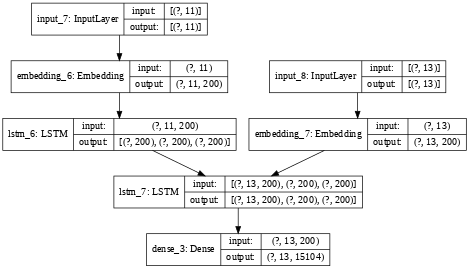

In [ ]:
######################
# Собираем тренировочную модель нейросети
######################
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary()) # выведем на экран информацию о построенной модели нейросети
plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)

### Обучение

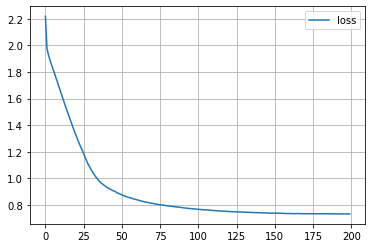

In [ ]:
#model.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/modelPro_v2.h5')

#Коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 12, verbose = 0, restore_best_weights = True)
#reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.6, patience=6, min_lr=1e-06, verbose = 1)
Checkpoint = ModelCheckpoint('modelPro_v2.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit([encoderForInput , decoderForInput], decoderForOutput, 
                    batch_size=50, epochs=200, verbose=1,
                    callbacks = [early_stopping, Checkpoint])

#Выводим график точности распознавания на обучающей и проверочной выборках
clear_output()
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.grid()
plt.show()

### Диалог

In [ ]:
######################
# Устанавливаем окончательные настройки и запускаем модель
######################

encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
  # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  # Создаём пустой массив размером (1, 1)
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

  stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
  decodedTranslation = '' # здесь будет собираться генерируемый ответ
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
    sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
    sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
        sampledWord = word # выбранное слово фиксируем в переменную sampledWord
    
    # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
    emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
    statesValues = [h, c] # и состояния, обновленные декодером
    # и продолжаем цикл с обновленными параметрами
  
  print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

Задайте вопрос : здравствуй
 почему ты не мне так ты ничего 
Задайте вопрос : пойдешь за меня на работу
 да но как же вы его чего в тебе не да 
Задайте вопрос : стой
 в чем дело 
Задайте вопрос : говоришь не то
 да 
Задайте вопрос : специально
 что это значит а как вы 
Задайте вопрос : проехали


KeyError: ignored

## Эксперименты с оптимизаторами на 100 эпохах

------------------------------------------------------------------------------------------
100 эпох обучения. Optimizer =  RMSprop


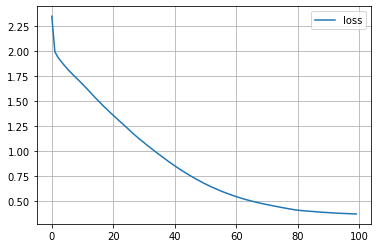

Задайте вопрос : здравствуй
 почему ты не бойся 
Задайте вопрос : не боюсь
 за день 
Задайте вопрос : стой
 в чем дело 
Задайте вопрос : опять не то говоришь
 и в чем же дело 
Задайте вопрос : я тебя не понимаю
 не будем об этом 
Задайте вопрос : хорошо
 а ты его его нет 


In [ ]:
os.chdir('/content/drive/My Drive/Занятие_13_Генерация текста/data')
#model.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/modelPro_v2_%r.h5'%(opt))

optim = ['RMSprop']
for opt in optim:

  ######################
  # Первый входной слой, кодер, выходной слой
  ######################
  encoderInputs = Input(shape=(11, )) # размеры на входе сетки (здесь будет encoderForInput)
  # Эти данные проходят через слой Embedding (длина словаря, размерность) 
  encoderEmbedding = Embedding(vocabularySize, 200,  mask_zero=True) (encoderInputs)
  # Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
  # Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
  encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
  encoderStates = [state_h, state_c]

  ######################
  # Второй входной слой, декодер, выходной слой
  ######################
  decoderInputs = Input(shape=(13, )) # размеры на входе сетки (здесь будет decoderForInput)
  # Эти данные проходят через слой Embedding (длина словаря, размерность) 
  # mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
  decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
  # Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c

  decoderLSTM = LSTM(200, return_state=True, return_sequences=True)


  decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
  # И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
  decoderDense = Dense(vocabularySize, activation='softmax') 
  output = decoderDense (decoderOutputs)

  model = Model([encoderInputs, decoderInputs], output)
  model.compile(optimizer = opt, loss='categorical_crossentropy')
  print('-'*90)
  print('100 эпох обучения. Optimizer = ', opt)
  #Коллбэки
  early_stopping = EarlyStopping(monitor = 'loss', patience = 12, verbose = 0, restore_best_weights = True)
  Checkpoint = ModelCheckpoint('modelPro_v2_%r.h5'%(opt), monitor='loss', verbose=0, save_best_only=True, save_weights_only=True)

  history = model.fit([encoderForInput , decoderForInput], decoderForOutput, 
                      batch_size=100, epochs=100, verbose=0,
                      callbacks = [early_stopping, Checkpoint])

  #Выводим график точности распознавания на обучающей и проверочной выборках
  #clear_output()
  plt.plot(history.history['loss'], label='loss')
  plt.legend()
  plt.grid()
  plt.show()

  ######################
  # Устанавливаем окончательные настройки и запускаем модель
  ######################

  encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

  for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
    # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
    statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
    # Создаём пустой массив размером (1, 1)
    emptyTargetSeq = np.zeros((1, 1))    
    emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

    stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
    decodedTranslation = '' # здесь будет собираться генерируемый ответ
    while not stopCondition : # пока не сработало стоп-условие
      # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
      # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
      decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
      
      #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
      sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
      sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
      for word , index in tokenizer.word_index.items():
        if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
          decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
          sampledWord = word # выбранное слово фиксируем в переменную sampledWord
      
      # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
      if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
        stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

      emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
      emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
      statesValues = [h, c] # и состояния, обновленные декодером
      # и продолжаем цикл с обновленными параметрами
    
    print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

------------------------------------------------------------------------------------------
100 эпох обучения. Optimizer =  Adam


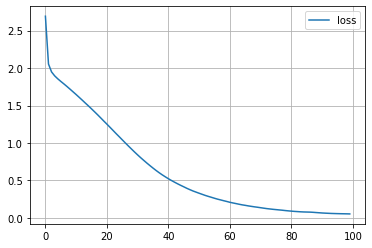

Задайте вопрос : здравствуй
 хочешь есть маленькая 
Задайте вопрос : я не маленькая девочка
 откуда ты действительно ваша свет 
Задайте вопрос : из дома
 жена 
Задайте вопрос : у меня нет жены
 а это 
Задайте вопрос : эта будет женой
 вот в эскадрилье 
Задайте вопрос : ты смеешься
 о чем дело 


In [ ]:
os.chdir('/content/drive/My Drive/Занятие_13_Генерация текста/data')
#model.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/modelPro_v2_%r.h5'%(opt))

optim = ['Adam']
for opt in optim:

  ######################
  # Первый входной слой, кодер, выходной слой
  ######################
  encoderInputs = Input(shape=(11, )) # размеры на входе сетки (здесь будет encoderForInput)
  # Эти данные проходят через слой Embedding (длина словаря, размерность) 
  encoderEmbedding = Embedding(vocabularySize, 200,  mask_zero=True) (encoderInputs)
  # Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
  # Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
  encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
  encoderStates = [state_h, state_c]

  ######################
  # Второй входной слой, декодер, выходной слой
  ######################
  decoderInputs = Input(shape=(13, )) # размеры на входе сетки (здесь будет decoderForInput)
  # Эти данные проходят через слой Embedding (длина словаря, размерность) 
  # mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
  decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
  # Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c

  decoderLSTM = LSTM(200, return_state=True, return_sequences=True)


  decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
  # И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
  decoderDense = Dense(vocabularySize, activation='softmax') 
  output = decoderDense (decoderOutputs)

  model = Model([encoderInputs, decoderInputs], output)
  model.compile(optimizer = opt, loss='categorical_crossentropy')
  print('-'*90)
  print('100 эпох обучения. Optimizer = ', opt)
  #Коллбэки
  early_stopping = EarlyStopping(monitor = 'loss', patience = 12, verbose = 0, restore_best_weights = True)
  Checkpoint = ModelCheckpoint('modelPro_v2_%r.h5'%(opt), monitor='loss', verbose=0, save_best_only=True, save_weights_only=True)

  history = model.fit([encoderForInput , decoderForInput], decoderForOutput, 
                      batch_size=100, epochs=100, verbose=0,
                      callbacks = [early_stopping, Checkpoint])

  #Выводим график точности распознавания на обучающей и проверочной выборках
  #clear_output()
  plt.plot(history.history['loss'], label='loss')
  plt.legend()
  plt.grid()
  plt.show()

  ######################
  # Устанавливаем окончательные настройки и запускаем модель
  ######################

  encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

  for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
    # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
    statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
    # Создаём пустой массив размером (1, 1)
    emptyTargetSeq = np.zeros((1, 1))    
    emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

    stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
    decodedTranslation = '' # здесь будет собираться генерируемый ответ
    while not stopCondition : # пока не сработало стоп-условие
      # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
      # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
      decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
      
      #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
      sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
      sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
      for word , index in tokenizer.word_index.items():
        if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
          decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
          sampledWord = word # выбранное слово фиксируем в переменную sampledWord
      
      # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
      if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
        stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

      emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
      emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
      statesValues = [h, c] # и состояния, обновленные декодером
      # и продолжаем цикл с обновленными параметрами
    
    print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

------------------------------------------------------------------------------------------
100 эпох обучения. Optimizer =  Nadam


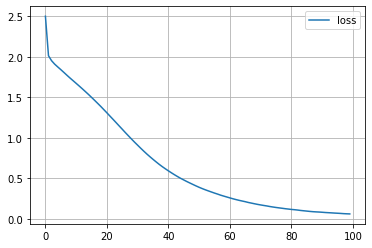

Задайте вопрос : здравствуй
 хочешь есть маленькая 
Задайте вопрос : не хочу и я не маленькая
 о чем ты люк 
Задайте вопрос : я не люк
 где же это 
Задайте вопрос : стой
 что же я тебе дам 
Задайте вопрос : дай денег
 что есть 
Задайте вопрос : много денег
 чего будем дать ему надо 


In [ ]:
os.chdir('/content/drive/My Drive/Занятие_13_Генерация текста/data')
#model.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/modelPro_v2_%r.h5'%(opt))

optim = ['Nadam']
for opt in optim:

  ######################
  # Первый входной слой, кодер, выходной слой
  ######################
  encoderInputs = Input(shape=(11, )) # размеры на входе сетки (здесь будет encoderForInput)
  # Эти данные проходят через слой Embedding (длина словаря, размерность) 
  encoderEmbedding = Embedding(vocabularySize, 200,  mask_zero=True) (encoderInputs)
  # Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
  # Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
  encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
  encoderStates = [state_h, state_c]

  ######################
  # Второй входной слой, декодер, выходной слой
  ######################
  decoderInputs = Input(shape=(13, )) # размеры на входе сетки (здесь будет decoderForInput)
  # Эти данные проходят через слой Embedding (длина словаря, размерность) 
  # mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
  decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
  # Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c

  decoderLSTM = LSTM(200, return_state=True, return_sequences=True)


  decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
  # И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
  decoderDense = Dense(vocabularySize, activation='softmax') 
  output = decoderDense (decoderOutputs)

  model = Model([encoderInputs, decoderInputs], output)
  model.compile(optimizer = opt, loss='categorical_crossentropy')
  print('-'*90)
  print('100 эпох обучения. Optimizer = ', opt)
  #Коллбэки
  early_stopping = EarlyStopping(monitor = 'loss', patience = 12, verbose = 0, restore_best_weights = True)
  Checkpoint = ModelCheckpoint('modelPro_v2_%r.h5'%(opt), monitor='loss', verbose=0, save_best_only=True, save_weights_only=True)

  history = model.fit([encoderForInput , decoderForInput], decoderForOutput, 
                      batch_size=100, epochs=100, verbose=0,
                      callbacks = [early_stopping, Checkpoint])

  #Выводим график точности распознавания на обучающей и проверочной выборках
  #clear_output()
  plt.plot(history.history['loss'], label='loss')
  plt.legend()
  plt.grid()
  plt.show()

  ######################
  # Устанавливаем окончательные настройки и запускаем модель
  ######################

  encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

  for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
    # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
    statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
    # Создаём пустой массив размером (1, 1)
    emptyTargetSeq = np.zeros((1, 1))    
    emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

    stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
    decodedTranslation = '' # здесь будет собираться генерируемый ответ
    while not stopCondition : # пока не сработало стоп-условие
      # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
      # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
      decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
      
      #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
      sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
      sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
      for word , index in tokenizer.word_index.items():
        if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
          decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
          sampledWord = word # выбранное слово фиксируем в переменную sampledWord
      
      # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
      if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
        stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

      emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
      emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
      statesValues = [h, c] # и состояния, обновленные декодером
      # и продолжаем цикл с обновленными параметрами
    
    print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

------------------------------------------------------------------------------------------
200 эпох обучения. Optimizer =  Adamax


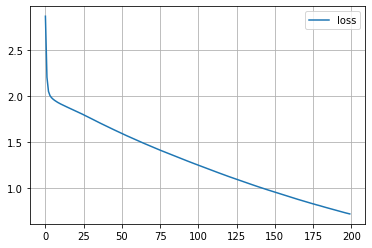

Задайте вопрос : здравствуй
 что случилось 
Задайте вопрос : пойдешь вместо меня на работу
 а куда 
Задайте вопрос : на работу
 да сэр 
Задайте вопрос : спасибо
 а что с тобой в виду 
Задайте вопрос : со мной все хорошо
 кто 
Задайте вопрос : женщина
 да не дикими 


In [13]:
os.chdir('/content/drive/My Drive/Занятие_13_Генерация текста/data')
#model.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/modelPro_v2_%r.h5'%(opt))

optim = ['Adamax']
for opt in optim:

  ######################
  # Первый входной слой, кодер, выходной слой
  ######################
  encoderInputs = Input(shape=(11, )) # размеры на входе сетки (здесь будет encoderForInput)
  # Эти данные проходят через слой Embedding (длина словаря, размерность) 
  encoderEmbedding = Embedding(vocabularySize, 200,  mask_zero=True) (encoderInputs)
  # Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
  # Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
  encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
  encoderStates = [state_h, state_c]

  ######################
  # Второй входной слой, декодер, выходной слой
  ######################
  decoderInputs = Input(shape=(13, )) # размеры на входе сетки (здесь будет decoderForInput)
  # Эти данные проходят через слой Embedding (длина словаря, размерность) 
  # mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
  decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
  # Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c

  decoderLSTM = LSTM(200, return_state=True, return_sequences=True)


  decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
  # И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
  decoderDense = Dense(vocabularySize, activation='softmax') 
  output = decoderDense (decoderOutputs)

  model = Model([encoderInputs, decoderInputs], output)
  model.compile(optimizer = opt, loss='categorical_crossentropy')
  print('-'*90)
  print('200 эпох обучения. Optimizer = ', opt)
  #Коллбэки
  early_stopping = EarlyStopping(monitor = 'loss', patience = 12, verbose = 0, restore_best_weights = True)
  Checkpoint = ModelCheckpoint('modelPro_v2_%r.h5'%(opt), monitor='loss', verbose=0, save_best_only=True, save_weights_only=True)

  history = model.fit([encoderForInput , decoderForInput], decoderForOutput, 
                      batch_size=100, epochs=200, verbose=0,
                      callbacks = [early_stopping, Checkpoint])

  #Выводим график точности распознавания на обучающей и проверочной выборках
  #clear_output()
  plt.plot(history.history['loss'], label='loss')
  plt.legend()
  plt.grid()
  plt.show()

  ######################
  # Устанавливаем окончательные настройки и запускаем модель
  ######################

  encModel, decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

  for _ in range(6): # задаем количество вопросов, и на каждой итерации в этом диапазоне:
    # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
    statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
    # Создаём пустой массив размером (1, 1)
    emptyTargetSeq = np.zeros((1, 1))    
    emptyTargetSeq[0, 0] = tokenizer.word_index['start'] # положим в пустую последовательность начальное слово 'start' в виде индекса

    stopCondition = False # зададим условие, при срабатывании которого, прекратится генерация очередного слова
    decodedTranslation = '' # здесь будет собираться генерируемый ответ
    while not stopCondition : # пока не сработало стоп-условие
      # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
      # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
      decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
      
      #argmax пробежит по вектору decOutputs'а[0,0,15104], найдет макс.значение, и вернёт нам номер индекса под которым оно лежит в массиве
      sampledWordIndex = np.argmax(decOutputs, axis=-1) # argmax возьмем от оси, в которой 15104 элементов. Получили индекс предсказанного слова.
      sampledWord = None # создаем переменную, в которую положим слово, преобразованное на естественный язык
      for word , index in tokenizer.word_index.items():
        if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
          decodedTranslation += ' {}'.format(word) # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ 
          sampledWord = word # выбранное слово фиксируем в переменную sampledWord
      
      # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
      if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
        stopCondition = True # то срабатывает стоп-условие и прекращаем генерацию

      emptyTargetSeq = np.zeros((1, 1)) # создаем пустой массив
      emptyTargetSeq[0, 0] = sampledWordIndex # заносим туда индекс выбранного слова
      statesValues = [h, c] # и состояния, обновленные декодером
      # и продолжаем цикл с обновленными параметрами
    
    print(decodedTranslation[:-3]) # выводим ответ сгенерированный декодером

# Выводы:
1. Сначала я обучил сеть с урока на 200 эпохах, чтобы посмотреть на достигаемый ей loss:
*результат ужасный!!! сетка переучилась*
2. Потом проверил влияние различных оптимайзеров на качество обучения но ограничился 100 эпохами чтобы не переучивать
3. Я достиг почти 0.01 на оптимайзерах Adam и Nadam. Судя по ответам сети - нет смысла еще улучшать обучение, так как естьпроблемы в обучающей выборке. Лучше не будет